# CPSC 330 Lecture 4

#### Lecture plan

- 👋
- **Turn on recording**
- Announcements
- Cross-validation True/False poll (5 min)
- Logistic regression intro (5 min)
- `CountVectorizer` and feature preprocessing pitfalls (35 min)
- Break (5 min)
- Logistic regression: `predict_proba` (10 min)
- Logistic regression: coefficients and interpretation (10 min)
- Logistic regression with continuous features (10 min)
- True/False questions (time-permitting)

## Announcements

- Add-Drop has passed - welcome to the course!
- hw1 grades posted, hw2 deadline passed, hw3 will posted later today.

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from plot_classifier import plot_classifier

## Cross-validation True/False poll (5 min)

https://piazza.com/class/kb2e6nwu3uj23?cid=178

## Logistic regression intro (5 min)

#### Motivating example 

- Sentiment analysis: predict the sentiment of text, such as a movie review.
- Targets: positive 👍 and negative 👎
- Features: words (e.g., *excellent*, *well* for 👍 and *boring* for 👎)

<blockquote> 
    <p>Review 1: This movie was <b>excellent</b>! The performances were oscar-worthy!  👍 </p> 
    <p>Review 2: What a <b>boring</b> movie! I almost fell asleep twice while watching it. 👎 </p> 
    <p>Review 3: I enjoyed the movie. <b>Excellent</b>! 👍 </p>             
</blockquote>  

#### Intuition behind a linear classifier

- Learn coefficients (weights) associated with different features

<img src='img/words_coeff.png' width="300" height="300" />

- Use these learned coefficients to make predictions. For example, consider the following review $x_i$. 
<blockquote> 
    <p>It got a bit <b>boring</b> at times but the direction was <b>excellent</b> and the acting was <b>flawless</b>. </p> 
</blockquote>

#### Linear classifier 

- $\textrm{score}(review) = $ coefficient(*boring*) + coefficient(*excellent*) + coefficient(*flawless*) = $-1.40 + 1.93 + 1.43 = 1.96$
- Since $score(review) = 1.96 > 0$, predict the review as positive 👍. 
- Components of a linear model
    - input features
    - coefficients (weights), one per feature
    - bias or intercept

#### Logistic regression

In particular, we will focus on 
- use `fit`, `predict`, `predict_proba`
- use `coef_` to interpret the model weights 


## Q&A

(Pause for Q&A)

## `CountVectorizer` and the Golden Rule (35 min)

#### Let's train it on a dataset

I have downloaded the [IMDB movie review dataset](https://www.kaggle.com/utathya/imdb-review-dataset) from Kaggle. You should be able to download it as well. I did not push it to the home repo because it is large and because I don't have permission to redistribute it.

In [37]:
imdb_df = pd.read_csv('data/imdb_master.csv', index_col=0, encoding="ISO-8859-1")
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]
imdb_df = imdb_df.sample(frac=0.2, random_state=999) # Take a subsample of the dataset for speed
imdb_df

,type,review,label,file
12438,test,As Jennifer Denuccio used to say on Square Peg...,neg,9946_2.txt
5705,test,"With Knightly and O'Tool as the leads, this fi...",neg,3886_3.txt
11675,test,"Take a bad script, some lousy acting and throw...",neg,9259_1.txt
9824,test,Strange things happen to Americans Will (Greg ...,neg,7593_3.txt
22581,test,"Sometimes, you're up late at night flipping th...",pos,7824_7.txt
...,...,...,...,...
31555,train,With a cast of stalwart British character acto...,neg,4650_2.txt
36478,train,There's a lot of movies that have set release ...,neg,9081_1.txt
35878,train,Welcome to movie 17 on the chilling classics 5...,neg,8541_1.txt
16040,test,"This is a forgotten classic of a film, and Har...",pos,1937_10.txt


In [38]:
imdb_df.shape

(10000, 4)

- Above, we used some key words in a review to decide how to classify it. 
- But here, we just have raw text:

In [39]:
imdb_df.loc[1,"review"]

"This is an example of why the majority of action films are the same. Generic and boring, there's really nothing worth watching here. A complete waste of the then barely-tapped talents of Ice-T and Ice Cube, who've each proven many times over that they are capable of acting, and acting well. Don't bother with this one, go see New Jack City, Ricochet or watch New York Undercover for Ice-T, or Boyz n the Hood, Higher Learning or Friday for Ice Cube and see the real deal. Ice-T's horribly cliched dialogue alone makes this film grate at the teeth, and I'm still wondering what the heck Bill Paxton was doing in this film? And why the heck does he always play the exact same character? From Aliens onward, every film I've seen with Bill Paxton has him playing the exact same irritating character, and at least in Aliens his character died, which made it somewhat gratifying...<br /><br />Overall, this is second-rate action trash. There are countless better films to see, and if you really want to s

We need a way to transform this raw text into use usual tabular format, where each column is a feature... hmm... 🤔

<br><br><br><br>

How about this: each word is a feature (column), and we check whether the word is present or absent in the review 💡

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

Make a CountVectorizer object:

In [41]:
vec = CountVectorizer(binary=True)

Note `binary=True` means just check whether a word is present (1) or absent (0), instead of counting the number of occurrences of the word.

Call `fit`:

In [42]:
vec.fit(imdb_df["review"]) 

CountVectorizer(binary=True)

For feature preprocessing objects, called _transformers_, we use `transform` instead of `predict` (indeed, it's not a prediction):

In [43]:
X = vec.transform(imdb_df["review"])

In [44]:
X[1].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

Hmm, is it only zeros for this first review?

In [45]:
X.shape

(10000, 52863)

That's a lot of columns!

In [46]:
vec.get_feature_names()[:20]

['00',
 '000',
 '001',
 '007',
 '0093638',
 '00pm',
 '00s',
 '01',
 '02',
 '03',
 '04',
 '041',
 '05',
 '06',
 '0615',
 '06th',
 '07',
 '08',
 '089',
 '0and']

- Ok, this seems like a lot of useless "words".
- We can use some hyperparameters of the `CountVectorizer` to just take more common words.
- Note: later in the course we will explore more options here.
  - For now we'll just focus on subsetting the features.

In [47]:
vec = CountVectorizer(min_df=50, binary=True) # words that appear at least n times

vec.fit(imdb_df["review"]) 

X = vec.transform(imdb_df["review"])

In [48]:
X.shape

(10000, 3243)

We can also explicitly ask for the top $n$ words:

In [49]:
vec = CountVectorizer(max_features=1000, binary=True) # max n columns

vec.fit(imdb_df["review"]) 

X = vec.transform(imdb_df["review"])

Note there is shorthand for this in scikit-learn:

In [50]:
X = vec.fit_transform(imdb_df["review"])

In [51]:
X.shape

(10000, 1000)

In [52]:
data_df = pd.DataFrame(data=X.toarray(), columns=vec.get_feature_names())
data_df

,10,20,30,80,able,about,above,absolutely,across,act,...,wrong,year,years,yes,yet,york,you,young,your,yourself
0,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,1,0,0,0,0,...,0,1,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,1,1,0
9997,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Q&A

(Pause for Q&A)

Ok, now we split the data...

In [53]:
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(X, 
                                                                        imdb_df['label'], 
                                                                        test_size = 0.20, 
                                                                        random_state = 12)

Ok, this seems reasonable. Are we all good?

<br><br><br><br><br><br>

### NO!!

- Remember, the test data should be **unseen** data.
- Here, the test data influenced how we preprocessed the training data:
  - We used it to determine which words were the top words.
  - In fact, some of our features might be words that don't even appear in the training set!!
  - Thus, **the test error is no longer an accurate measure of how our model generalizes to unsees data**.
- This is called The Golden Rule of ML: the test data should not influence the training process in any way.

## The "Golden Rule"

- Previously, we used cross-validation to inform our choice of the least overfit model.
- Is this okay? It can be, if we don't do this too many times.
- If we use it too many times, we suffer from "optimization bias".

- The "golden rule" is that we need to be extremely vigilant about what data is being used for what.
- A test set should only be used "once".  
- Even if only used once, it won't be a perfect representation of deployment error:
  1. Bad luck (which gets worse if it's a smaller set of data)
  2. The deployment data comes from a different distribution
  3. And if it's used more than once, then you have another problem, which is that it influenced training and is no longer "unseen data".

Avoid this 3rd issue! The other two are bad enough.

Back to our dataset. We need to start over...

In [62]:
# Just to be safe
imdb_df = pd.read_csv('data/imdb_master.csv', index_col=0, encoding="ISO-8859-1")
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]
imdb_df = imdb_df.sample(frac=0.2, random_state=999)

In [63]:
# STEP 1
imdb_train, imdb_test = train_test_split(imdb_df, test_size=0.2, random_state=123)

In [64]:
X_train_imdb_raw = imdb_train['review']
y_train_imdb = imdb_train['label']

X_test_imdb_raw = imdb_test['review']
y_test_imdb = imdb_test['label']

In [65]:
vec = CountVectorizer(min_df=50)

In [66]:
X_train_imdb = vec.fit_transform(X_train_imdb_raw)

In [67]:
X_test_imdb = vec.fit_transform(X_test_imdb_raw)

Now surely we're all good, right?

<br><br><br><br><br><br>

### NOPE

In [68]:
dt = DecisionTreeClassifier()

In [69]:
dt.fit(X_train_imdb, y_train_imdb);

In [70]:
dt.predict(X_test_imdb)

ValueError: Number of features of the model must match the input. Model n_features is 2714 and input n_features is 858 

In [71]:
X_train_imdb.shape

(8000, 2714)

In [72]:
X_test_imdb.shape

(2000, 858)

- What happened here?
- We fit the transformer on the training data, and transformed.
- Then we fit the transformer on the test data, and transformed.
- Now our data set makes no sense - we have a different number of columns in our train/test set!
- So, for example, the decision tree will split on a word "amazing", which is feature 2000, but then when we predict, we don't even have that feature!
- This is not a Golden Rule issue, it's just a preprocessing failure.
  - But note how the Golden Rule issue is harder to catch, because there's no Python error message.

In fact, if we had used `max_features` instead of `min_df` we wouldn't have even gotten a Python error message! See below:

In [77]:
vec = CountVectorizer(max_features=1000)

In [86]:
X_train_imdb = vec.fit_transform(X_train_imdb_raw)

In [87]:
vec.get_feature_names()[:3]

['10', '20', '80']

In [88]:
X_test_imdb = vec.fit_transform(X_test_imdb_raw);

In [89]:
vec.get_feature_names()[:3]

['10', '20', '30']

In [82]:
dt = DecisionTreeClassifier()

In [83]:
dt.fit(X_train_imdb, y_train_imdb);

In [84]:
dt.predict(X_test_imdb)

array(['neg', 'pos', 'pos', ..., 'pos', 'neg', 'pos'], dtype=object)

- Note: no error message.
- The problem is that the coefficients correspond to the **order** of the features, so the results will be completely invalid.

#### Attempt 3 (I promise it will be OK this time)

In [90]:
# Just to be safe
imdb_df = pd.read_csv('data/imdb_master.csv', index_col=0, encoding="ISO-8859-1")
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]
imdb_df = imdb_df.sample(frac=0.2, random_state=999)

In [91]:
# STEP 1
imdb_train, imdb_test = train_test_split(imdb_df, test_size=0.2, random_state=123)

In [92]:
X_train_imdb_raw = imdb_train['review']
y_train_imdb = imdb_train['label']

X_test_imdb_raw = imdb_test['review']
y_test_imdb = imdb_test['label']

In [93]:
vec = CountVectorizer(min_df=50, binary=True)

I am setting `binary=True` which gives just 1 or 0 for the features (word is present or absent); by default it _counts_ the number of occurrences of the word. I am using binary to be consistent with the motivating example at the start of class.

In [94]:
X_train_imdb = vec.fit_transform(X_train_imdb_raw)

We do not want this next line!!!

In [95]:
# vec.fit(X_test_imdb_raw);

We transform the test data with the transformer _fit on the training data_!!

In [96]:
X_test_imdb = vec.transform(X_test_imdb_raw);

Ok, let's give this a try:

In [99]:
dt = DecisionTreeClassifier()
dt.fit(X_train_imdb, y_train_imdb);

In [100]:
dt.score(X_train_imdb, y_train_imdb)

1.0

In [101]:
dt.score(X_test_imdb, y_test_imdb)

0.696

## Q&A

(Pause for Q&A)

## Break (5 min)



## Logistic regression: `predict_proba` (10 min)

In [110]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_imdb, y_train_imdb);

In [111]:
lr.score(X_train_imdb, y_train_imdb)

0.982125

In [112]:
lr.score(X_test_imdb, y_test_imdb)

0.826

Cool, we got a better test error this way!

#### Predicting probabilities

- Logistic regression seems to do fairly well on this task.
- Furthermore, we have a new and useful method, `predict_proba`.
- `predict` returns the class with the highest probability.
- Can we find the reviews where our classifier is most confident or least confident?
- How about reviews where the classifier is not very confident? 

In [115]:
probs = lr.predict_proba(X_test_imdb)
probs

array([[1.19863093e-02, 9.88013691e-01],
       [3.86858977e-01, 6.13141023e-01],
       [2.22224668e-05, 9.99977778e-01],
       ...,
       [9.31319007e-01, 6.86809929e-02],
       [7.52883742e-01, 2.47116258e-01],
       [9.42890481e-01, 5.71095187e-02]])

In [116]:
probs.shape

(2000, 2)

- It gives two columns, the probability of class 0 and the probability of class 1. 
- We only really care about one of them, since they add to 1. Let's take the second column:

In [117]:
lr.predict_proba(X_test_imdb)[:,1]

array([0.98801369, 0.61314102, 0.99997778, ..., 0.06868099, 0.24711626,
       0.05710952])

What's the most positive and most negative review according to our classifier?  


In [118]:
np.max(lr.predict_proba(X_test_imdb)[:,1])

0.9999999999961944

Wow! Let's find that review:

In [119]:
most_positive_ind = np.argmax(lr.predict_proba(X_test_imdb)[:,1])
most_positive_ind

311

In [120]:
print(X_test_imdb_raw.iloc[most_positive_ind])

How strange the human mind is; this center of activity wherein perceptions of reality are formed and stored, and in which one's view of the world hinges on the finely tuned functioning of the brain, this most delicate and intricate processor of all things sensory. And how much do we really know of it's inner-workings, of it's depth or capacity? What is it in the mind that allows us to discern between reality and a dream? Or can we? Perhaps our sense of reality is no more than an impression of what we actually see, like looking at a painting by Monet, in which the vanilla sky of his vision becomes our reality. It's a concept visited by filmmaker Cameron Crowe in his highly imaginative and consciousness-altering film, `Vanilla Sky,' starring Tom Cruise and Penelope Cruz. At the age of thirty-three, David Aames (Cruise) inherits a publishing empire left to him by his father. His fifty-one percent controlling interest, however, has made him something of a marked man, as there are seven mem

Most negative review:

In [121]:
most_negative_ind = np.argmax(lr.predict_proba(X_test_imdb)[:,0])
most_negative_ind

382

In [122]:
print(X_test_imdb_raw.iloc[most_negative_ind])

I'm a big horror film buff, particularly of the 1980's subgenres. Name one Â? I've probably seen it. Last year, a new little horror movie that seemed to slip under mainstream radar called "Saw" was about to hit theaters. I was moderately excited. Having not heard anything about it, I thought it looked quite promising judging by the previews and posters (well, except the back and white ones with the severed hands and feet...those just looked terrible!) I saw the film on opening night. It was one of the worst experiences of my life. This movie was literally mentally and psychically painful to watch. Because it was scary?...NO! Because it was one of the most awful movies I had ever had the displeasure of seeing! First off, the construction of the screenplay and editing was utterly atrocious, even by horror movie standards. Starting off a sequence in an interrogation room with a victim (Shawnee Smith) who recently survived a serial killer's attack, then showing a flashback of what she surv

## Q&A

(Pause for Q&A)

## Logistic regression: coefficients and interpretation (10 min)

- One of the primary advantage of linear classifiers is their ability to interpret models. 
- What features are most useful for prediction? What words are swaying it positive or negative?

#### Let's find the most informative words for positive and negative reviews 

- The information you need is exposed by the `coef_` attribute of [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) object. 
- The vocabulary (mapping from feature indices to actual words) can be obtained as follows: 

In [123]:
lr.coef_

array([[-0.75012956,  0.6608511 ,  0.01059772, ..., -0.64070402,
        -0.4605339 ,  0.5454647 ]])

In [124]:
# Get features (words in our case)
vocab = vec.get_feature_names()
vocab[:30]

['000',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '17',
 '1950',
 '1970',
 '20',
 '2001',
 '2005',
 '25',
 '30',
 '40',
 '50',
 '60',
 '70',
 '70s',
 '80',
 '80s',
 '90',
 'abandoned',
 'ability',
 'able',
 'about',
 'above',
 'absolute']

In [125]:
weights = lr.coef_.ravel()
weights[:30]

array([-7.50129564e-01,  6.60851105e-01,  1.05977242e-02,  3.34600292e-02,
        8.48638876e-01, -9.45170915e-03,  4.79057862e-01, -9.06174277e-01,
        1.97400667e-01,  1.12528680e-01, -7.71444923e-01,  1.88195278e-01,
        6.74804846e-04, -8.88009056e-02,  9.93395172e-01, -2.94852506e-01,
        2.62119174e-02, -3.17310311e-01,  2.65652798e-01,  5.23118573e-01,
        1.16331386e-01, -5.86748345e-02,  2.21687243e-01, -9.51128836e-02,
        8.55791738e-01, -2.07358879e-01,  9.11424370e-02,  2.56764184e-02,
        2.54371235e-01,  3.97110856e-01])

In [126]:
words_weights_df = pd.DataFrame(data=weights, index=vocab, columns=['Weight'])
words_weights_df

,Weight
000,-0.750130
10,0.660851
100,0.010598
11,0.033460
12,0.848639
...,...
yourself,0.171232
youth,-0.576386
zero,-0.640704
zombie,-0.460534


In [127]:
words_weights_df.sort_values(by="Weight", ascending=False)

,Weight
perfect,1.803678
spectacular,1.732960
touching,1.703111
surprisingly,1.638610
gotten,1.541692
...,...
worst,-2.004586
lame,-2.040910
poorly,-2.088691
awful,-2.227446


- These coefficients make sense!
- Let's use this to explore one of the test cases:

In [92]:
ex = 5
lr.predict_proba(X_test_imdb)[ex,1]

0.0018543169525522983

In [93]:
X_test_imdb_raw.iloc[ex]

"Its plain to see why the makers of Scary Movie found it so easy to spoof these 'teen slasher' movies. They are so unbelievably formulaic. And if Valentine had been released a year or so earlier, I'm sure they would have been spoofing this film too - that's if they found any actual original material to distinguish it from the Screams, I know what you did last summers, and Urban Legends.<br /><br />Valentine offers nothing new to this genre, except a better than usual ending which, of course, leaves lots of room for the inevitable sequel. As always, a masked psychotic killer stalks a bunch of beautiful young women, killing the main character's friends, one by one, in typically over the top style. Lots of T&A on display, no character development, bad acting, and overly elaborate bloodshed.<br /><br />The thing I can't stand about these kind of movies is that they pass themselves off as 'who done its?'. The thing is that they aren't because the motive is only revealed once the killer has 

We can find which of the vocabulary words are present in this review:

In [96]:
words_in_ex = X_test_imdb[ex].toarray().ravel().astype(bool)
words_in_ex

array([False, False, False, ..., False, False, False])

How many of the words are in this review?

In [98]:
np.sum(words_in_ex)

183

In [97]:
np.array(vocab)[words_in_ex]

array(['about', 'acting', 'actual', 'after', 'alive', 'all', 'almost',
       'along', 'always', 'an', 'and', 'another', 'any', 'anybody',
       'anyway', 'are', 'aren', 'as', 'at', 'bad', 'beautiful', 'because',
       'been', 'being', 'better', 'br', 'bunch', 'but', 'by', 'can',
       'character', 'clear', 'coming', 'count', 'course', 'demons',
       'development', 'did', 'didn', 'display', 'doesn', 'dog', 'don',
       'done', 'during', 'earlier', 'easy', 'ending', 'escape',
       'everybody', 'except', 'father', 'film', 'followed', 'for',
       'formula', 'found', 'friend', 'friends', 'from', 'genre', 'given',
       'good', 'had', 'hard', 'has', 'have', 'his', 'if', 'important',
       'in', 'instead', 'is', 'issue', 'it', 'its', 'killer', 'killing',
       'kills', 'kind', 'know', 'last', 'lead', 'leaves', 'left', 'lines',
       'lots', 'made', 'main', 'make', 'makers', 'making', 'manages',
       'material', 'may', 'more', 'mother', 'movie', 'movies', 'much',
       'murde

In [99]:
ex_df = pd.DataFrame(data=weights[words_in_ex], index=np.array(vocab)[words_in_ex], columns=['Weight'])
ex_df

,Weight
about,-0.105881
acting,-0.372368
actual,-0.158372
after,-0.138115
alive,0.025010
...,...
women,-0.336860
would,-0.219344
year,-0.021090
you,0.257461


In [100]:
ex_df.sum()

Weight   -6.702551
dtype: float64

- As we can see, the sum is negative, so we predicted that it's a negative review.
- Also, the more negative this value is, the closer to 0 the predicted probability would be. 
  - If this value were exactly 0, the predicted probability would be exactly 0.5.

#### Why people use logistic regression?  

- Logistic regression is extremely popular!
- Fast training and testing.
  - Training on huge datasets.
- Interpretability
  - Weights are how much a given feature changes the prediction and in what direction.

## Q&A

(Pause for Q&A)

## Logistic regression with continuous features (5 min)

In [134]:
cilantro_df = pd.read_csv('data/330-students-cilantro.csv')
cilantro_df.columns = ["meat", "grade", "cilantro"]

In [135]:
cilantro_train, cilantro_test = train_test_split(cilantro_df, random_state=1)

In [137]:
cilantro_X_train = cilantro_train[["meat", "grade"]]
cilantro_y_train = cilantro_train["cilantro"]

In [138]:
lr = LogisticRegression()
lr.fit(cilantro_X_train, cilantro_y_train);

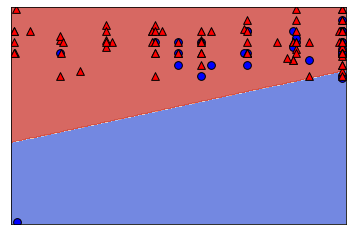

In [140]:
plot_classifier(cilantro_X_train, cilantro_y_train, lr);

- There are still some coefficients/weights being multiplied by the features.
- A linear classifier "slices the space in half" with a "hyperplane" (with 2 features, this is just a line).

Let's look at the predicted probabilties:

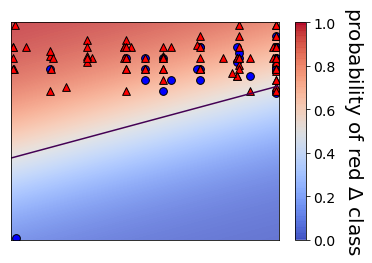

In [141]:
plot_classifier(cilantro_X_train, cilantro_y_train, lr, proba=True);

An important hyperparameter: `C` (default is `C=1.0`).

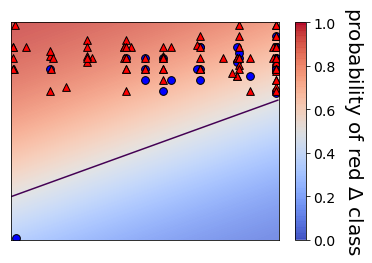

In [148]:
lr = LogisticRegression(C=.001)
lr.fit(cilantro_X_train, cilantro_y_train);
plot_classifier(cilantro_X_train, cilantro_y_train, lr, proba=True);

- Smaller `C` leads to less confident predictions (probabilties closer to 0.5).
- In general, we say smaller `C` leads to a less complex model (like a shallower decision tree).
  - Complex models are really a larger `C` in conjunction with lots of features.
  - Here we only have 2 features.

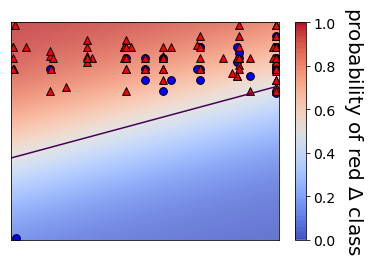

In [149]:
lr = LogisticRegression(C=1000)
lr.fit(cilantro_X_train, cilantro_y_train);
plot_classifier(cilantro_X_train, cilantro_y_train, lr, proba=True);

Back to the IMDB dataset:

In [152]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_imdb, y_train_imdb)
lr.score(X_train_imdb, y_train_imdb)

0.982125

In [153]:
lr.score(X_test_imdb, y_test_imdb) 

0.826

In [154]:
lr = LogisticRegression(max_iter=1000, C=10_000)
lr.fit(X_train_imdb, y_train_imdb)
lr.score(X_train_imdb, y_train_imdb)

1.0

In [155]:
lr.score(X_test_imdb, y_test_imdb) 

0.798

Above: higher `C` leads to more overfitting.

In [157]:
lr = LogisticRegression(C=0.01)
lr.fit(X_train_imdb, y_train_imdb)
lr.score(X_train_imdb, y_train_imdb)

0.89325

In [158]:
lr.score(X_test_imdb, y_test_imdb) 

0.843

Above: lower `C` leads to less overfitting`.

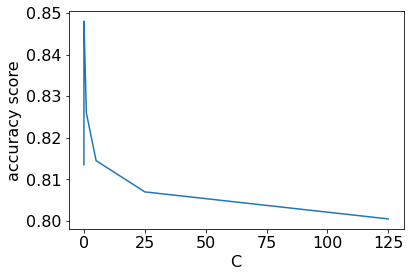

In [162]:
C_vals = 5.0**np.arange(-4,4)
scores = []
for C in C_vals:
    score = LogisticRegression(max_iter=1000, C=C).fit(X_train_imdb, y_train_imdb).score(X_test_imdb, y_test_imdb)
    scores.append(score)
plt.plot(C_vals, scores);
plt.xlabel("C");
plt.ylabel("accuracy score");

## Q&A

(Pause for Q&A)

## True/False questions

1. With `CountVectorizer`, we should `fit` on the training data and `transform` on both the train/test data.
2. `predict` returns the positive class if the predicted probability of the positive class is greater than 0.5.
3. Logistic regression overfits less than decision trees.
4. With logistic regression, we learn one weight per training example.